<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : 다양한 OCR모델 비교하기

# 1 사전 준비

## 1-1. 패키지 불러오기

In [ ]:
import os
import matplotlib.pyplot as plt
import keras_ocr 
import pytesseract
from PIL import Image
from pytesseract import Output
# Google Cloud Vision 설치
# !pip install --upgrade google-api-python-client
# !pip install google-cloud-vision

## 1-2. 기본 code

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  './data_eng/my_google_api_key.json'

# Google Cloud Vision API
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

# tesseract의 문자 검출 및 이미지 자르기 (detection)
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng', 
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

# tesseract의 잘린 이미지 단어 인식하기
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

def recognize_images2(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    image = Image.open(image_path)
    recognized_data = pytesseract.image_to_string(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    print(recognized_data['text'])

# 2 검증용 데이터셋 준비

## 2-1. 소스 사진 확보 방법

* 개인적으로 오린 책사진 일부분(2개) 및 아래 이미지 공유 사이트에서 나머지(8개)다운로드
* 이미지 소스의 url: https://unsplash.com/s/photos/text
* 이미지 소스 제공자
> Brigitte Tohm <br>
> Eileen Pan <br>
> takwa abdo <br>
> Chris Curry <br>
> Fab Lentz <br>
> Viktor Forgacs<br>
> Alex Azabache <br>
> Anthony Garand <br>

## 2-2. 사진 특징 및 파일 구성

█ 사진 특징

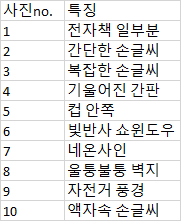

In [ ]:
# 검증용 데이터셋

image_locs = [
  './data_eng/01_BOOK.jpg',
  './data_eng/02_HANDWRITTEN.jpg',
  './data_eng/03_HANDWRITTEN2_brigitte-tohm-EAay7Aj4jbc-unsplash.jpg',
  './data_eng/04_SIGNBOARD_eileen-pan-5d5DSRQ5dUc-unsplash.jpg',
  './data_eng/05_CUP_takwa-abdo-W8_qA5I4LIo-unsplash.jpg',
  './data_eng/06_SHOW-WINDOW_chris-curry-UJij-wz7w88-unsplash.jpg',
  './data_eng/07_NEONSIGN_fab-lentz-mRMQwK513hY-unsplash.jpg',
  './data_eng/08_WALLPAPER_viktor-forgacs-qe5mRoPJjQ0-unsplash.jpg',
  './data_eng/09_BICYCLE_alex-azabache-V83v-MYB_Z8-unsplash.jpg',
  './data_eng/10_FRAME_anthony-garand-7RxMsJdvt7k-unsplash.jpg'
]
num_img = len(image_locs)
images = [ keras_ocr.tools.read(image) for image in image_locs]

# tesseract의 cropped images를 위한 전용 디렉토리
work_dirs = [
    './data_eng/tesseract/01',
    './data_eng/tesseract/02',
    './data_eng/tesseract/03',
    './data_eng/tesseract/04',
    './data_eng/tesseract/05',
    './data_eng/tesseract/06',
    './data_eng/tesseract/07',
    './data_eng/tesseract/08',
    './data_eng/tesseract/09',
    './data_eng/tesseract/10'
]
img_file_paths = [
  './data_eng/tesseract/01/01_BOOK.jpg',
  './data_eng/tesseract/02/02_HANDWRITTEN.jpg',
  './data_eng/tesseract/03/03_HANDWRITTEN2_brigitte-tohm-EAay7Aj4jbc-unsplash.jpg',
  './data_eng/tesseract/04/04_SIGNBOARD_eileen-pan-5d5DSRQ5dUc-unsplash.jpg',
  './data_eng/tesseract/05/05_CUP_takwa-abdo-W8_qA5I4LIo-unsplash.jpg',
  './data_eng/tesseract/06/06_SHOW-WINDOW_chris-curry-UJij-wz7w88-unsplash.jpg',
  './data_eng/tesseract/07/07_NEONSIGN_fab-lentz-mRMQwK513hY-unsplash.jpg',
  './data_eng/tesseract/08/08_WALLPAPER_viktor-forgacs-qe5mRoPJjQ0-unsplash.jpg',
  './data_eng/tesseract/09/09_BICYCLE_alex-azabache-V83v-MYB_Z8-unsplash.jpg',
  './data_eng/tesseract/10/10_FRAME_anthony-garand-7RxMsJdvt7k-unsplash.jpg'
]

# 3 모델별 예측 성능 비교

## 3-1. Google Cloud Vision 모델 예측

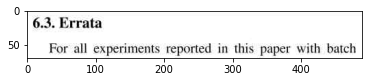

Texts:

"6.3. Errata
For all experiments reported in this paper with batch"

"6.3"

"."

"Errata"

"For"

"all"

"experiments"

"reported"

"in"

"this"

"paper"

"with"

"batch"
bounds: (437,47),(479,47),(479,64),(437,64)


In [ ]:
# Google Cloud Vision 예측: 01
i = 0
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

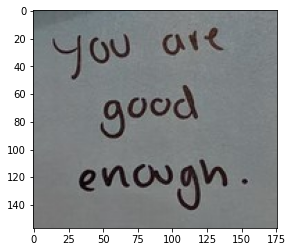

Texts:

"are
you
good
enough."

"are"

"you"

"good"

"enough"

"."
bounds: (143,108),(159,107),(160,137),(144,138)


In [ ]:
# Google Cloud Vision 예측: 02
i = 1
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

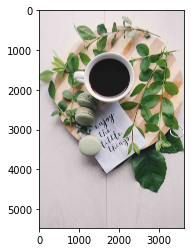

Texts:

"enjoy
the
little
things"

"enjoy"

"the"

"little"

"things"
bounds: (1703,3444),(2229,3123),(2341,3308),(1815,3628)


In [ ]:
# Google Cloud Vision 예측: 03
i = 2
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

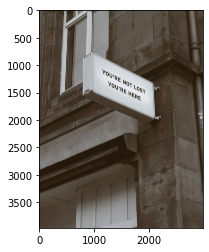

Texts:

"YOU'RE NOT LOST
YOU'RE HERE"

"YOU'RE"

"NOT"

"LOST"

"YOU'RE"

"HERE"
bounds: (1630,1473),(1875,1589),(1846,1650),(1601,1534)


In [ ]:
# Google Cloud Vision 예측: 04
i = 3
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

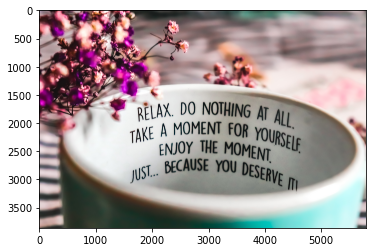

Texts:

"RELAX. DO NOTHING AT ALL.
TAKE A MOMENT FOR YOURSELF
ENJOY THE MOMENT.
JUST... BECAUSE YOU DESERVE ITI"

"RELAX"

"."

"DO"

"NOTHING"

"AT"

"ALL"

"."

"TAKE"

"A"

"MOMENT"

"FOR"

"YOURSELF"

"ENJOY"

"THE"

"MOMENT"

"."

"JUST"

"..."

"BECAUSE"

"YOU"

"DESERVE"

"ITI"
bounds: (4419,2960),(4644,3037),(4576,3238),(4350,3162)


In [ ]:
# Google Cloud Vision 예측: 05
i = 4
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

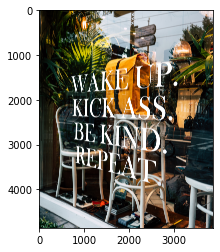

Texts:

"FINE
XXX
ONOOP
****
WAKE UP.
KICKASS
BE KIND.
REPEAT
ONL
→
ONOOP
QNOOP
397
WILA
UJIUNI"

"FINE"

"XXX"

"ONOOP"

"****"

"WAKE"

"UP"

"."

"KICKASS"

"BE"

"KIND"

"."

"REPEAT"

"ONL"

"→"

"ONOOP"

"QNOOP"

"397"

"WILA"

"UJIUNI"
bounds: (2840,4852),(2903,4806),(2912,4819),(2849,4865)


In [ ]:
# Google Cloud Vision 예측: 06
i = 5
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

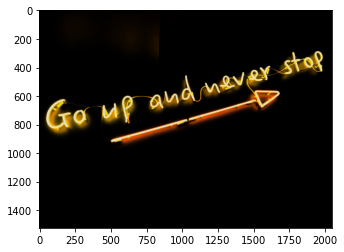

Texts:

"Go up and never stop"

"Go"

"up"

"and"

"never"

"stop"
bounds: (1663,287),(1978,217),(2030,450),(1715,520)


In [ ]:
# Google Cloud Vision 예측: 07
i = 6
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

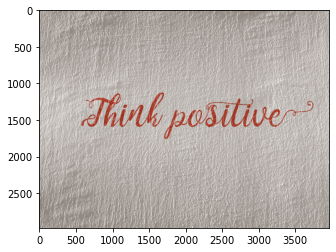

Texts:

"Think positive"

"Think"

"positive"
bounds: (1737,1154),(3360,1238),(3333,1764),(1710,1680)


In [ ]:
# Google Cloud Vision 예측: 08
i = 7
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

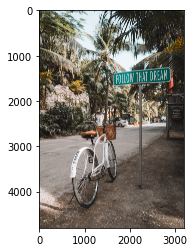

Texts:

"XMNU
FAVORIT
FAVORIT
BEACH
BEACH
PANTHER
MATE
FOLLOW THAT DREAM
KAYA
STEL- RAMION
ABLUE
LoLita
LoLita
Tulum
Quintana Roo"

"XMNU"

"FAVORIT"

"FAVORIT"

"BEACH"

"BEACH"

"PANTHER"

"MATE"

"FOLLOW"

"THAT"

"DREAM"

"KAYA"

"STEL-"

"RAMION"

"ABLUE"

"LoLita"

"LoLita"

"Tulum"

"Quintana"

"Roo"
bounds: (3081,2347),(3128,2349),(3127,2372),(3080,2370)


In [ ]:
# Google Cloud Vision 예측: 09
i = 8
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

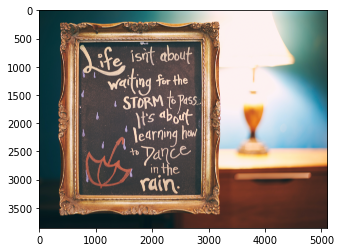

Texts:

"Life isn't about
waiting for the
STORM to pass..
It's about
learning how
6
W
to
Dance
in the
rain.
1"

"Life"

"isn't"

"about"

"waiting"

"for"

"the"

"STORM"

"to"

"pass"

".."

"It's"

"about"

"learning"

"how"

"6"

"W"

"to"

"Dance"

"in"

"the"

"rain"

"."

"1"
bounds: (967,1091),(1043,1131),(1005,1204),(928,1165)


In [ ]:
# Google Cloud Vision 예측: 10
i = 9
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

## 3-2. Keras-ocr 모델 예측
 keras-ocr 모델 다운로드 및 예측

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()
prediction_groups = [pipeline.recognize([url]) for url in image_locs]

# 예측결과에서 text만 추출
predictions = []
for i in range(0, len(prediction_groups)):
    predictions.append(prediction_groups[i][0])
predictions_word = []
for j in range(0, len(predictions)):
    predictions_word.append([word  for word, na in predictions[j]])

length: 11
prediction: ['63', 'errata', 'for', 'experiments', 'reported', 'this', 'with', 'batch', 'all', 'in', 'paper']


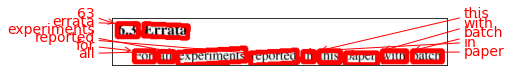

In [ ]:
# Keras-ocr 모델 예측: 01
i = 0
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 4
prediction: ['atl', 'jou', 'good', 'enough']


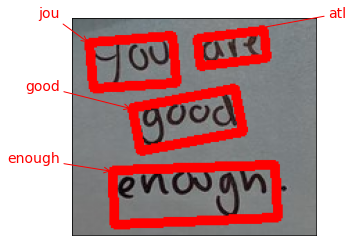

In [ ]:
# Keras-ocr 모델 예측: 02
i = 1
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 3
prediction: ['teyy', 'little', 'things']


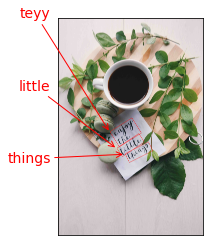

In [ ]:
# Keras-ocr 모델 예측: 03
i = 2
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 5
prediction: ['youre', 'not', 'youre', 'lost', 'sere']


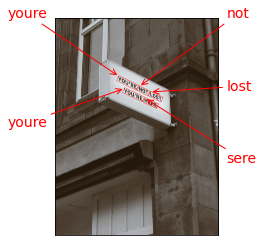

In [ ]:
# Keras-ocr 모델 예측: 04
i = 3
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 18
prediction: ['do', 'nothing', 'relax', 'at', 'all', 'moment', 'for', 'a', 'take', 'yourele', 'the', 'enjoy', 'moment', 'because', 'you', 'deserve', 'just', 't']


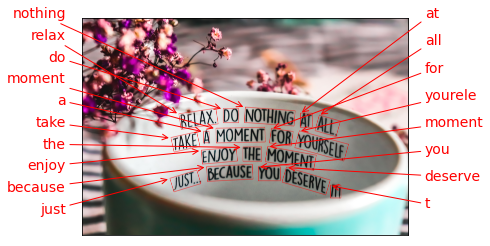

In [ ]:
# Keras-ocr 모델 예측: 05
i = 4
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 10
prediction: ['dge', 'fine', 'lp', 'wane', 'kickass', 'bekind', 'repeat', 'onoop', 'emoop', 'gnoop']


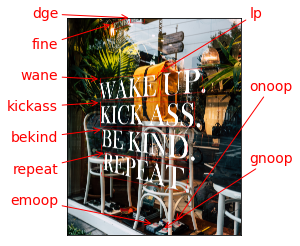

In [ ]:
# Keras-ocr 모델 예측: 06
i = 5
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 4
prediction: ['oystol', 'ogaiv', 'up', 'cto']


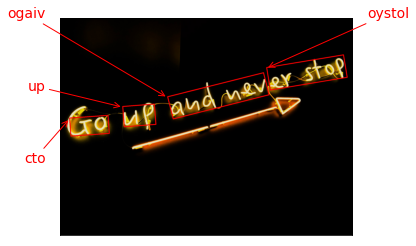

In [ ]:
# Keras-ocr 모델 예측: 07
i = 6
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 2
prediction: ['hian', 'hositwe']


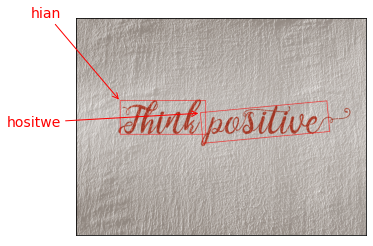

In [ ]:
# Keras-ocr 모델 예측: 08
i = 7
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 13
prediction: ['dream', 'that', 'follow', 'lolita', 'lolita', 'kaya', 'tulum', 'quintana', 'roo', 'blue', 'favorit', 'dnw', 'beackes']


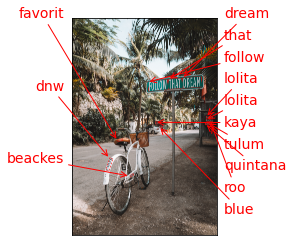

In [ ]:
# Keras-ocr 모델 예측: 09
i = 8
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 15
prediction: ['about', 'isint', 'ife', 'waiting', 'the', 'for', 'tlass', 'storm', 'dout', 'lts', 'how', 'slanig', 'the', 'in', 'rain']


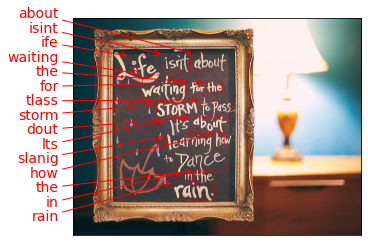

In [ ]:
# Keras-ocr 모델 예측: 10
i = 9
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

## 3-3. Tesseract 모델 예측

In [ ]:
# detection
cropped_image_path_lists = []
for i in range(0, len(work_dirs)):
    cropped_image_path_lists.append(crop_word_regions(img_file_paths[i], work_dirs[i]))

./data_eng/tesseract/01\0000.png
./data_eng/tesseract/01\0001.png
./data_eng/tesseract/01\0002.png
./data_eng/tesseract/01\0003.png
./data_eng/tesseract/01\0004.png
./data_eng/tesseract/01\0005.png
./data_eng/tesseract/01\0006.png
./data_eng/tesseract/01\0007.png
./data_eng/tesseract/01\0008.png
./data_eng/tesseract/01\0009.png
./data_eng/tesseract/01\0010.png
./data_eng/tesseract/01\0011.png
./data_eng/tesseract/02\0000.png
./data_eng/tesseract/02\0001.png
./data_eng/tesseract/02\0002.png
./data_eng/tesseract/02\0003.png
./data_eng/tesseract/02\0004.png
./data_eng/tesseract/02\0005.png
./data_eng/tesseract/02\0006.png
./data_eng/tesseract/02\0007.png
./data_eng/tesseract/03\0000.png
./data_eng/tesseract/04\0000.png
./data_eng/tesseract/04\0001.png
./data_eng/tesseract/05\0000.png
./data_eng/tesseract/06\0000.png
./data_eng/tesseract/07\0000.png
./data_eng/tesseract/08\0000.png
./data_eng/tesseract/08\0001.png
./data_eng/tesseract/08\0002.png
./data_eng/tesseract/08\0003.png
./data_eng

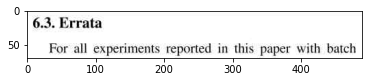

TO

6.4.

Errata

ror

“atl

experiments

reported

in

(his

Paper

with

Hatch

Done


In [ ]:
# Tesseract 모델 예측: 01
i = 0
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

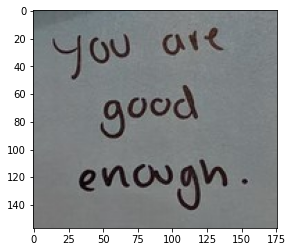

Oe

OC)

%

ies

<

VAO’N)

a


Done


In [ ]:
# Tesseract 모델 예측: 02
i = 1
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

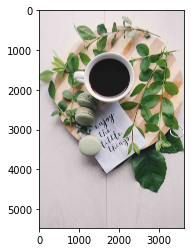

, ,

Done


In [ ]:
# Tesseract 모델 예측: 03
i = 2
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

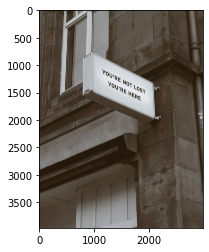



Done


In [ ]:
# Tesseract 모델 예측: 04
i = 3
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

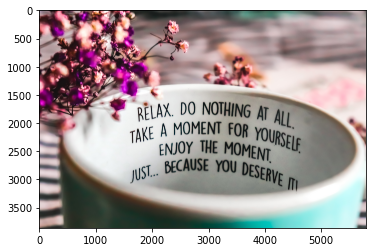

: : 7 | : | . }

Done


In [ ]:
# Tesseract 모델 예측: 05
i = 4
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

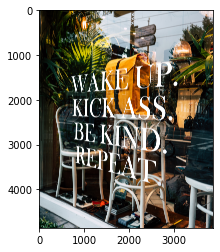

!

Done


In [ ]:
# Tesseract 모델 예측: 06
i = 5
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

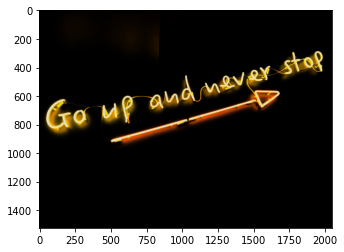

Go yp enh

Done


In [ ]:
# Tesseract 모델 예측: 07
i = 6
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

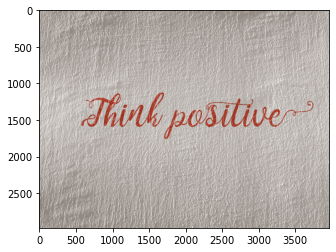

4

Pi

"s

me i)

J

5

4

i

|

-

,

|


4

is

,




a

-

A

4


,


ss

ry

,

a

5

4


?


a

-

yi


4

A

,

:

/

J

@

-

f

|

“4

4

w.

f


/

*

:

4




t,

:

=

/

J

/


7

/


f

“4,

‘

“”

y

ys;

r

by

f

= |

7

“




*


}

?

Ff


\y

j

:

:


"

7

.

,

/


:

.

ae

3


i

!

v

!


-

.

.

?

*+~_

SB: :




|

é


is





‘

™


s

4



3

—

Zé


a

,

%

,





_

v4

.

/

'

:

(

<

Y ot


1

Fa

?


-

“?@


;

,

,

Fie

J

¢

—

-


>

>

a

i

>





}

-~

>

Y

.


uy

4

.

'

-

.

-

f

,

JS


f

|

4


Z

.

>

a

‘

|

é

rig

;

A

i

;


i

i

j

,

>

_

a

_

a

J

£


'

t

ae,

>

,

.

3

7

f


,

:

:


'

A

ie





ff

:

e

4

4

-*

Jj

d





,

a



;


:


=

:


/

é

|


J

—

7


:

:




u

5

a

ra

j


;

“

;

;

ey

.

-


-

:

-

}

'

.

;


a

_

/

7

y

Pry!

ig

Cla

_

7

4

r

:


:

)

f

\

2

f

— j=

f


»


'

}

.

-

>

$

,

»

+

“a

7

y


}

+

a

:



.


-

2.

/

PP

4

é

r



,


,

> Ve

In [ ]:
# Tesseract 모델 예측: 08
i = 7
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

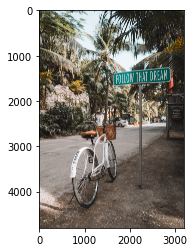

LoLitea

+

LoLitea

ltulum

SQUintans

cine


Done


In [ ]:
# Tesseract 모델 예측: 09
i = 8
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

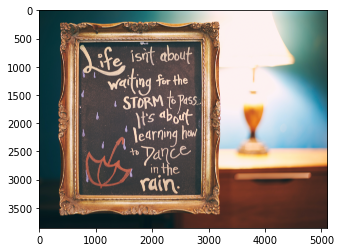

|


7 (Uf

Veatting

for

the


os


Yearning

he

|

|

il : : ‘ L

a -


Done


In [ ]:
# Tesseract 모델 예측: 10
i = 9
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

# 4 모델별 예측 성능 평가

█ 수동계산 및 주관평가: 인식성공 여부 및 성공율은 수기로 직접 세어서 작성하고, 전반적 주관적 느낌을 추가함.

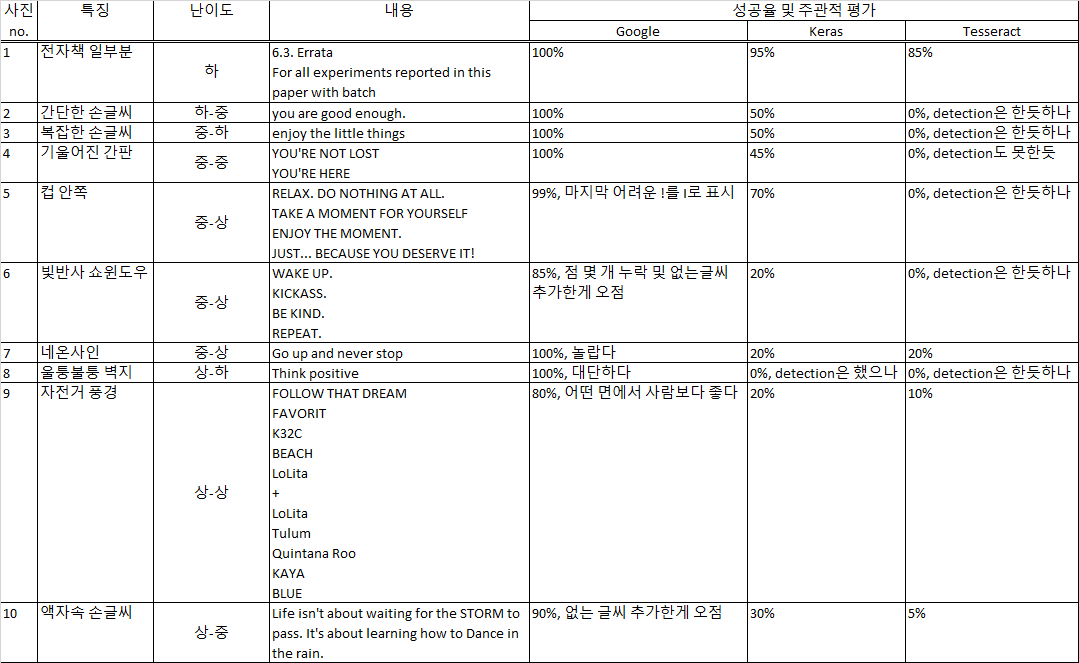

# 5 회고


* 속도등의 여타 평가기준을 제외하고, 오직 예측성능에 한해서만 평가하였다.
* Google Cloud Vision은 압도적으로 성능이 좋았으며, 다양한 이미지에 대해서 높은 성능을 보였다.
* 